<a href="https://colab.research.google.com/github/hangjoni/nlp/blob/main/Sentiment_Analysis_Using_Universal_Sentence_Embedder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparing data

In [50]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Input, Dropout
from sklearn.utils import shuffle
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import os
import pandas as pd
DATASET_ENCODING = "ISO-8859-1"

In [9]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!if [ -f "sentiment140.zip" ]; then echo "Already downloaded data"; else kaggle datasets download -d kazanova/sentiment140; fi


 73% 59.0M/80.9M [00:00<00:00, 172MB/s]
100% 80.9M/80.9M [00:00<00:00, 180MB/s]


In [57]:
df = pd.read_csv('sentiment140.zip', encoding=DATASET_ENCODING, header=None)
df = df.iloc[:,[0,-1]]
df.columns=['sentiment', 'tweet']
df = pd.concat([df.query("sentiment==0").sample(20000), df.query("sentiment==4").sample(20000)])
df.sentiment = df.sentiment.map({0:0, 4:1})
df = shuffle(df).reset_index(drop=True)
df, df_test = train_test_split(df, test_size=0.2)

In [58]:
df.dtypes

sentiment     int64
tweet        object
dtype: object

In [59]:
df

,sentiment,tweet
35936,0,pray for the people that was at air france rio...
7533,1,"@fadzzi we going over your place later, hana n..."
34130,1,"@divacoachdabney Will do, thanks!"
3155,0,Has just done a small dance because yes you gu...
27520,0,@edpryorbeatz F'n self-fulfilling prophecies!!
...,...,...
20064,0,@Emz2009 so sad emma u sad to be leaving the ...
15976,0,@lylebignon Ouch! but also a little bit beca...
22509,0,Hi @wplifestream the ff.im short links beginni...
8470,0,@darker_artic - A bad one?


In [39]:
## Load Universal Sentence Encoder

In [40]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [14]:
embed(['Python is a functional programming language']).numpy().shape

(1, 512)

In [61]:
def vectorize(df):
  embedded_tweets = embed(df['tweet'].values.tolist()).numpy()
  targets = df.sentiment.values
  return embedded_tweets, targets

embedded_tweets, targets = vectorize(df)

## Model

In [65]:
model = Sequential()
model.add(Input(shape=(512,),dtype='float32'))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [66]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 128)               65664     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 65        
                                                                 
Total params: 73985 (289.00 KB)
Trainable params: 73985 (289.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Train and evaluate

In [67]:
num_epochs = 10
batch_size = 32

history = model.fit(embedded_tweets,
                    targets,
                    epochs = num_epochs,
                    validation_split=0.1,
                    shuffle=True,
                    batch_size=batch_size)

Epoch 1/10
900/900 [==============================] - 3s 3ms/step - loss: 0.5060 - acc: 0.7564 - val_loss: 0.4740 - val_acc: 0.7703
Epoch 2/10
900/900 [==============================] - 3s 3ms/step - loss: 0.4668 - acc: 0.7833 - val_loss: 0.4725 - val_acc: 0.7700
Epoch 3/10
900/900 [==============================] - 2s 2ms/step - loss: 0.4553 - acc: 0.7903 - val_loss: 0.4708 - val_acc: 0.7688
Epoch 4/10
900/900 [==============================] - 2s 2ms/step - loss: 0.4388 - acc: 0.8015 - val_loss: 0.4695 - val_acc: 0.7716
Epoch 5/10
900/900 [==============================] - 2s 2ms/step - loss: 0.4284 - acc: 0.8064 - val_loss: 0.4742 - val_acc: 0.7681
Epoch 6/10
900/900 [==============================] - 2s 2ms/step - loss: 0.4150 - acc: 0.8150 - val_loss: 0.4719 - val_acc: 0.7688
Epoch 7/10
900/900 [==============================] - 3s 3ms/step - loss: 0.4019 - acc: 0.8223 - val_loss: 0.4798 - val_acc: 0.7666
Epoch 8/10
900/900 [==============================] - 2s 2ms/step - loss: 0.

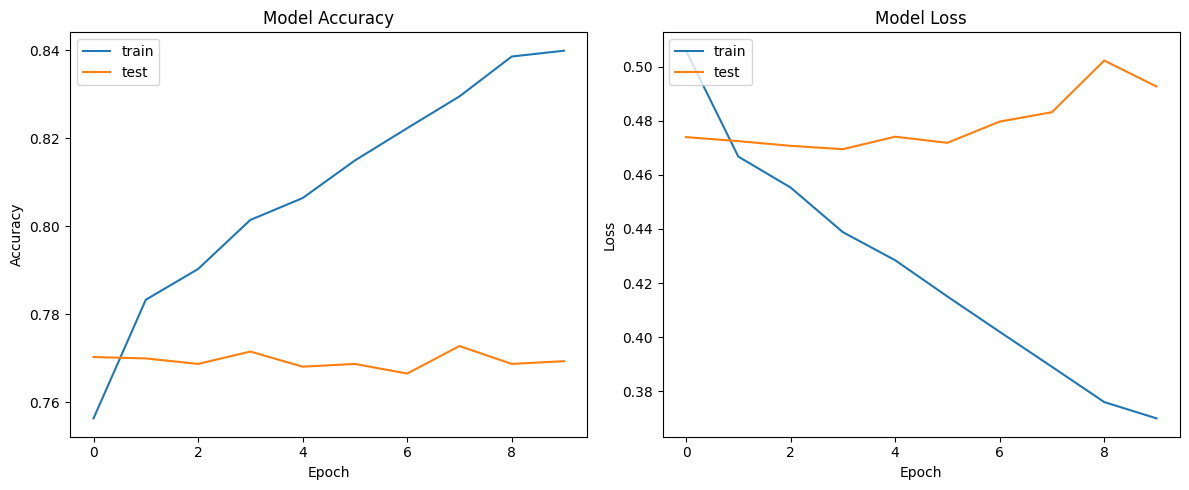

In [68]:
import matplotlib.pyplot as plt

# Figure 1: Model Accuracy
plt.figure(figsize=(12, 5))  # Set the overall figure size

# First subplot for accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Second subplot for loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Loss')
plt.ylabel('Loss')  # Fixed label to 'Loss'
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Display the plots
plt.tight_layout()  # Adjust spacing between plots
plt.show()


Loss looks rather weird

In [69]:
from sklearn.metrics import accuracy_score
embed_test,targets_test = vectorize(df_test)
predictions = model.predict(embed_test).astype(int)
accuracy_score(predictions,targets_test)*100

250/250 [==============================] - 0s 1ms/step


50.837500000000006

- The model is a simple multi-layer perceptron which overfit quickly. Test performance attains only 50% accuracy
- Areas to improve:
1. Investigate whether Universal Sentence Embedding could be replaced with a better language model
2. Improve the architecture of the model: tune drop out, try different sizes, try CNN or RNN
3. Use pre-training like in ULMFit
4. Use triangle learning rate like in ULMFit